In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
im =cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0 

In [3]:
s = 10
h, w = gray.shape

scale_space = np.empty((h, w, s), dtype=np.float32)
radius = np.arange(1, 11, 1)
sigmas = radius / np.sqrt(2)

#Gaussian kernal
for i, sigma in enumerate(sigmas):
    log_hw = 3*np.max(sigma)
    X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1, 1), np.arange(-log_hw, log_hw + 1, 1))
    log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
    f_log = cv.filter2D(gray, -1, log)
    scale_space[:, :, i] = f_log

In [4]:
#Scale space extrema detection
extrema = np.zeros_like(scale_space, dtype=bool)

for k in range(1, s-1):
    for i in range(1, h-1):
        for j in range(1, w-1):
            # Extract 3x3x3 neighborhood
            neighborhood = scale_space[i-1:i+2, j-1:j+2, k-1:k+2]
            center_value = scale_space[i, j, k]
            
            # Check if center is the maximum in the neighborhood
            if center_value == np.max(neighborhood):
                extrema[i, j, k] = True

In [5]:
# Optional threshold to remove noise responses
threshold = 0.295
extrema = extrema & (scale_space > threshold)

# Get coordinates of blob centers
y, x, s_idx = np.where(extrema)
radii = np.sqrt(2) * sigmas[s_idx]

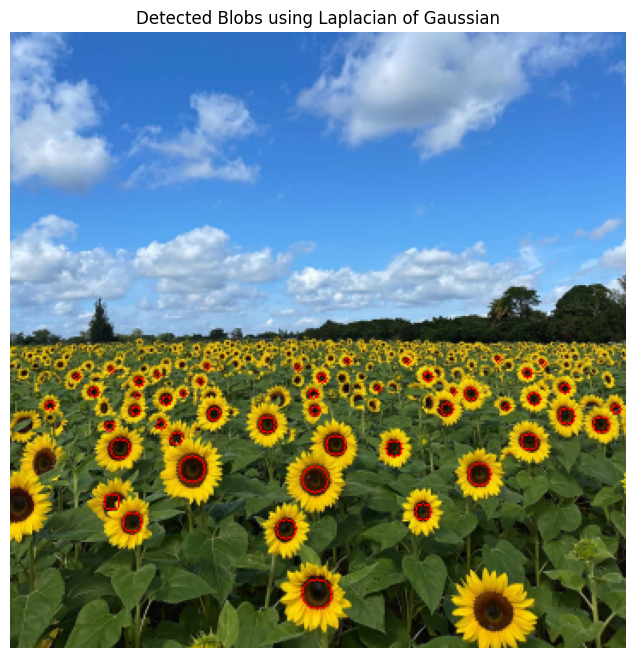

In [6]:
out = im.copy()
for (x0, y0, r) in zip(x, y, radii):
    if r > 1:  # ignore too small
        cv.circle(out, (x0, y0), int(r), (0, 0, 255), 1)

plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
plt.title('Detected Blobs using Laplacian of Gaussian')
plt.axis('off')
plt.show()

In [7]:
#Question 3
background = cv.imread('bigstock-147560168.jpg')  
flag   = cv.imread('Flag_of_Sri_Lanka.svg.jpg') 

In [8]:
h, w = flag.shape[:2]
src_pts = np.array([[0,0], [w,0], [w,h], [0,h]], dtype=np.float32)
h_t, w_t = background.shape[:2]
dst_pts = np.array([
    [619, 288],   # top-left on target
    [1262, 264],   # top-right
    [1263, 607],  # bottom-right
    [611, 608]   # bottom-left
], dtype=np.float32)

In [9]:
#Compute homography
H, status = cv.findHomography(src_pts, dst_pts)

#Wrap the flag with background image
warped_flag = cv.warpPerspective(flag, H, (w_t, h_t))

#Create mask for blending
gray = cv.cvtColor(warped_flag, cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)

#Simple alpha blend (hard paste)
alpha = 0.5  
mask_bool = mask.astype(bool)
result = background.copy()
result[mask_bool] = cv.addWeighted(warped_flag, alpha, background, 1-alpha, 0)[mask_bool]

# Save
cv.imwrite("flag_blended.jpg", result)

True

In [60]:
# #Question 4
# def extract_sift_features(img):
#     gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
#     sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1)
#     keypoints, descriptors = sift.detectAndCompute(gray, None)

#     return keypoints, descriptors

In [61]:
# def match_sift_bruteforce(des1, des2, use_ratio_test=True, ratio=0.75):
#     bf = cv.BFMatcher()
#     knn_matches = bf.knnMatch(des1, des2, k=2)
#     good_matches = []
#     for m_n in knn_matches:
#         if len(m_n) != 2:
#             continue  # skip if fewer than 2 matches returned for some reason
#         m, n = m_n
#         if m.distance < ratio * n.distance:
#             good_matches.append(m)
#     return good_matches

In [37]:
# def draw_matches(img1, kp1, img2, kp2, matches, max_matches=100):
#     img_matches = cv.drawMatches(cv.cvtColor(img1, cv.COLOR_RGB2GRAY), 
#                                  kp1, cv.cvtColor(img2, cv.COLOR_RGB2GRAY), kp2, 
#                                  matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#     return img_matches

In [36]:
# # a)
# img1 = cv.imread('img1.ppm')
# img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

# img2 = cv.imread('img5.ppm')
# img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

# kp1, des1 = extract_sift_features(img1)
# kp2, des2 = extract_sift_features(img2)

# match = match_sift_bruteforce(des1, des2)
# matched_img = draw_matches(img1, kp1, img2, kp2, match)

# plt.figure(figsize=(10, 10))
# plt.imshow(matched_img)
# plt.title("Best matched features")
# plt.axis('off')

In [30]:
from skimage import transform

In [31]:
def get_sift_features(img1, img2):
    # Convert to grayscale
    img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)

    # Get SIFT descriptors
    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1) 
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    # Match using Brute Force Matcher
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio to filter best matches
    best_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            best_matches.append(m)

    return best_matches, keypoints1, keypoints2

(-0.5, 1599.5, 639.5, -0.5)

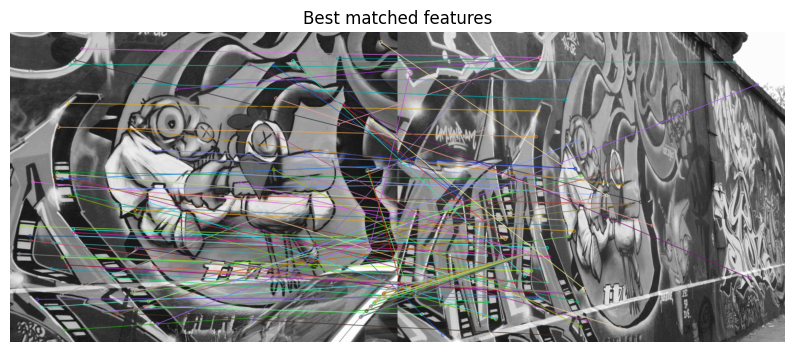

In [32]:
img1 = cv.imread("img1.ppm")
assert img1 is not None
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img2 = cv.imread("img5.ppm")
assert img2 is not None
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

best_matches, keypoints1, keypoints2 = get_sift_features(img1, img2)

plt.figure(figsize=(10, 10))
matched_img = cv.drawMatches(cv.cvtColor(img1, cv.COLOR_BGR2GRAY), keypoints1, cv.cvtColor(img2, cv.COLOR_BGR2GRAY), keypoints2, best_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matched_img)
plt.title("Best matched features")
plt.axis('off')

In [38]:
def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis = 1))

    return np.where(errors < thres)[0]

In [41]:
def find_best_homography(good_matches, keypoints1, keypoints5):
    # Array of all the matching points
    src_full = []
    dst_full = []

    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))

    src_full = np.array(src_full)
    dst_full = np.array(dst_full)

    # RANSAC for finding best homography
    num_points = 4
    thres = 0.1
    d = 0.5 * len(good_matches)
    iters = 1000

    best_homography = None
    best_inlier_count = 0
    best_inliers = None

    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)

        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))

        src_points = np.array(src_points)
        dst_points = np.array(dst_points)

        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)
        #print(f'Iteration {i}: No. of inliers = {len(inliers)}')

        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers

    print(f'Best no. of inliers = {best_inlier_count}')
    return best_homography, best_inliers

Best no. of inliers = 22


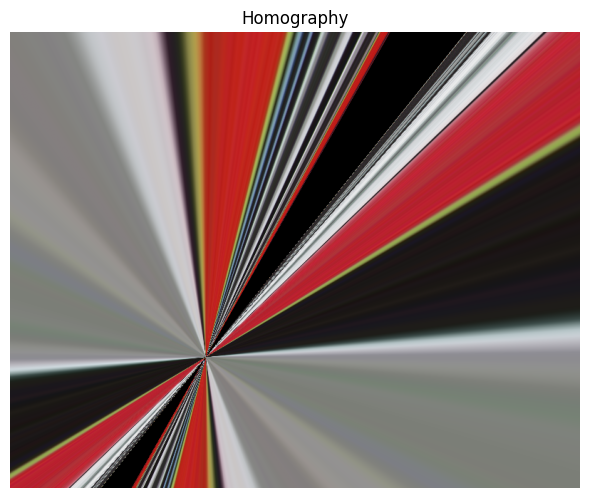

Number of inliers: 22


In [42]:
np.random.seed(62)
pad = 100

# Warp img1 initially (identity, optional)
# final_transformed_image = transform.warp(img1, transform.ProjectiveTransform(np.identity(3)).inverse)
# Just warp once with tform after RANSAC

# Step 1: Get SIFT matches
good_matches, keypoints1, keypoints2 = get_sift_features(img1, img2)

# Step 2: Find best homography using RANSAC
# Increase threshold for inliers
tform, best_inliers = find_best_homography(good_matches, keypoints1, keypoints2)

# Step 3: Warp img1 onto img2 using the best homography
final_transformed_image = transform.warp(img1, tform.inverse)

# Step 4: Visualize
plt.figure(figsize=(6, 6))
plt.imshow(final_transformed_image)
plt.title(f"Homography")
plt.axis('off')
plt.tight_layout()
plt.show()

# Optional: Print number of inliers
print("Number of inliers:", len(best_inliers))
